In [256]:
import matplotlib.pyplot as plt
#from PIL import Image
import matplotlib.image as mpimg
import numpy as np
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.metrics
import pandas as pd
from sklearn.model_selection import train_test_split
import os, shutil, random
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler

pd.options.mode.chained_assignment = None  # default='warn'

## Explore Metadata

In [2]:
meta = pd.read_csv('data/HAM10000_metadata.csv')

In [3]:
meta['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

#### There is a class imbalance concerning diagnoses. We have to deal with that later on.

In [4]:
meta.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [124]:
meta[meta['age'].isnull()].sum()

lesion_id       HAM_0001186HAM_0002660HAM_0000372HAM_0000948HA...
image_id        ISIC_0033391ISIC_0033750ISIC_0033685ISIC_00336...
dx              bklbklbklbklbklbklbklbklbklbklmelmelnvnvnvnvnv...
dx_type         consensusconsensusconsensusconsensusconsensusc...
age                                                             0
sex             unknownunknownunknownunknownunknownunknownunkn...
localization    unknownunknownunknownunknownunknownunknownunkn...
duplicate       no_duplicatesno_duplicatesno_duplicatesno_dupl...
dtype: object

In [11]:
meta[meta['sex']== "unknown"].count()

lesion_id       57
image_id        57
dx              57
dx_type         57
age             10
sex             57
localization    57
dtype: int64

### Identify lesion_IDs with multiple images for the validation set
To ensure that we don't have the same images in the train and validation set

In [4]:
uni = meta.groupby('lesion_id').count()

In [5]:
uni = uni[uni['image_id'] == 1]

In [6]:
unique_list = list(uni.index)

In [7]:
# define function to identify if a lesion id has duplicate images
def is_duplicate(x):
    
    unique_list = list(uni.index)
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

In [8]:
meta['duplicate'] = meta['lesion_id']

In [9]:
meta['duplicate'] = meta['duplicate'].apply(is_duplicate)

In [10]:
no_dupl = meta[meta.duplicate == "no_duplicates"]

In [11]:
meta['duplicate'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicate, dtype: int64

In [318]:
meta

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

            duplicate   img_nr  
0      has_duplicates  0027419  
1      has_duplicates  0025030  
2      has_duplicates  0026769  
3      has_duplicates  0025661  
4      has_duplicates  0031633  
...               ...      ...  
10010  has_duplicates  0033084  
10011  has_duplicates  0033550  
10012  has_duplicates  0033536  
10013  has_duplicates  0032854  
10014  has_duplicates  0032258  

[10015 rows x 9 columns]

### Create a validation set with only non-duplicate IDs

In [12]:
y= no_dupl.dx

In [13]:
# apply the train-test-split. Here we only need Xtest. Stratified splitting ensures equal distribution of classes
_, val_data = train_test_split(no_dupl, random_state=43, stratify=y, test_size=0.20)

In [14]:
val_data['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

In [15]:
val_data.shape

(1103, 8)

### Remove validation data from the training data

In [16]:
train_data = pd.concat([meta, val_data]).drop_duplicates(keep=False)

In [17]:
train_data.shape

(8912, 8)

### Create folder structure for training and validation data and load images

In [18]:
train_data = train_data.set_index("image_id")
val_data = val_data.set_index("image_id")

train_id = list(train_data.index)
test_id = list(val_data.index)

In [20]:
source_dir = "/Users/leona/PythonWork/Github_Projects/Final_Pro/data/ISIC2018_Task3_Training_Input/"

In [84]:
dirs = []

# Create train and validation directory
train_dir = os.path.join(source_dir, "train")
dirs.append(train_dir)
validation_dir = os.path.join(source_dir, "validation")
dirs.append(validation_dir)

# Create training subfolders for diagnoses
train_nv = os.path.join(train_dir, "nv")
dirs.append(train_nv)
train_mel = os.path.join(train_dir, "mel")
dirs.append(train_mel)
train_bkl = os.path.join(train_dir, "bkl")
dirs.append(train_bkl)
train_bcc = os.path.join(train_dir, "bcc")
dirs.append(train_bcc)
train_akiec = os.path.join(train_dir, "akiec")
dirs.append(train_akiec)
train_vasc = os.path.join(train_dir, "vasc")
dirs.append(train_vasc)
train_df = os.path.join(train_dir, "df")
dirs.append(train_df)

# Create validation subfolders for diagnoses
validation_nv = os.path.join(validation_dir, "nv")
dirs.append(validation_nv)
validation_mel = os.path.join(validation_dir, "mel")
dirs.append(validation_mel)
validation_bkl = os.path.join(validation_dir, "bkl")
dirs.append(validation_bkl)
validation_bcc = os.path.join(validation_dir, "bcc")
dirs.append(validation_bcc)
validation_akiec = os.path.join(validation_dir, "akiec")
dirs.append(validation_akiec)
validation_vasc = os.path.join(validation_dir, "vasc")
dirs.append(validation_vasc)
validation_df = os.path.join(validation_dir, "df")
dirs.append(validation_df)

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [85]:
train = os.listdir("/Users/leona/PythonWork/Github_Projects/Final_Pro/data/ISIC2018_Task3_Training_Input/")

for picture in train_id:
    pname = str(picture + '.jpg')
    label = train_data.loc[picture,'dx']
    
    if pname in train: 
        src = os.path.join(source_dir, pname)
        # destination path to image
        dst = os.path.join(train_dir, label, pname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)   

In [86]:
for picture in test_id:
    
    pname = picture + '.jpg'
    label = val_data.loc[picture,'dx']
    
    if pname in train:
        src = os.path.join(source_dir, pname)
        dst = os.path.join(validation_dir, label, pname)
        shutil.copyfile(src, dst)   

In [251]:
val_data.loc()

'nv'

In [87]:
print(len(os.listdir(source_dir +'train/nv')))
print(len(os.listdir(source_dir + 'train/mel')))
print(len(os.listdir(source_dir + 'train/bkl')))
print(len(os.listdir(source_dir + 'train/bcc')))
print(len(os.listdir(source_dir + 'train/akiec')))
print(len(os.listdir(source_dir + 'train/vasc')))
print(len(os.listdir(source_dir + 'train/df')))

5822
1067
1011
479
297
129
107


In [88]:
print(len(os.listdir(source_dir +'validation/nv')))
print(len(os.listdir(source_dir + 'validation/mel')))
print(len(os.listdir(source_dir + 'validation/bkl')))
print(len(os.listdir(source_dir + 'validation/bcc')))
print(len(os.listdir(source_dir + 'validation/akiec')))
print(len(os.listdir(source_dir + 'validation/vasc')))
print(len(os.listdir(source_dir + 'validation/df')))

883
46
88
35
30
13
8


### Perform image augmentation to counteract class imbalance

In [90]:
diagnoses = ["df", "mel","bkl", "bcc", "akiec", "vasc"]

In [91]:
for d in diagnoses:
    
# Create temporary directories for augmented images
# Base directory:
    aug_dir = os.path.join(source_dir,'aug_dir') 
    if not os.path.exists(aug_dir):
        os.mkdir(aug_dir)
    
# Directories for diagnostic classes
    img_dir = os.path.join(aug_dir, d)
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

# Choose a class
    img_class = d

# List all images in the train directory and copy it to the aug folder
    img_list = os.listdir(source_dir + 'train/' + img_class)
    
    for i in img_list: 
        src = os.path.join(source_dir + 'train/' + img_class, i)
        dst = os.path.join(img_dir,i)
        shutil.copyfile(src, dst)

### Create an image data generator ###

    path = aug_dir # path to the target directory. It should contain one subdirectory per class
    save_path = img_dir
    
    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=90,
        featurewise_center=True,
        featurewise_std_normalization=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=[0.8,1.0],
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.8,1.2),
        fill_mode='reflect')
    
    batch_size = 50
    
    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpeg',
                                            save_prefix='',
                                            target_size=(224,224),
                                              color_mode='rgb',
                                            batch_size=batch_size, shuffle=False) #important! Set Shuffle=False!
    
   
    
    num_wanted = 6000
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_wanted-num_files)/batch_size))


    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
    
    img_list = sorted(img_list)
    aug_list = os.listdir(img_dir)

# rename augmented images so that we can refer them back to the original image later on

    for number,image in enumerate(img_list):
        for filename in aug_list:
            if f"_{number}_" in filename:
                filename_new = image[5:12] + filename
                os.rename(os.path.join(img_dir,filename), os.path.join(img_dir,filename_new))

    for augfile in os.listdir(img_dir):
        if augfile not in img_list:
           shutil.move(img_dir + '/' + augfile, source_dir + 'train/' + img_class + '/' + augfile)

    
    shutil.rmtree(aug_dir)

Found 107 images belonging to 1 classes.


/Users/leona/anaconda3/envs/finalpro/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/leona/anaconda3/envs/finalpro/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1067 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 297 images belonging to 1 classes.
Found 129 images belonging to 1 classes.


In [92]:
print(len(os.listdir(source_dir +'train/nv')))
print(len(os.listdir(source_dir + 'train/mel')))
print(len(os.listdir(source_dir + 'train/bkl')))
print(len(os.listdir(source_dir + 'train/bcc')))
print(len(os.listdir(source_dir + 'train/akiec')))
print(len(os.listdir(source_dir + 'train/vasc')))
print(len(os.listdir(source_dir + 'train/df')))

5822
5885
5855
5798
5990
5210
4330


### Print random sample of augmented and original images per class

In [188]:
def generate_plot_pics(img_class):
    img_dir = source_dir + 'train/' + img_class
    ## -------------------------- ##
    ##   plot the generated data
    ## -------------------------- ##
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.1,wspace=0.05,
                    left=0,right=1,bottom=1, top=2)

    i = 1
    for imgnm in random.sample(os.listdir(img_dir),16):
        print(imgnm)
        ax = fig.add_subplot(4, 4, i,xticks=[],yticks=[],title=f"{imgnm}") 
        img = load_img(source_dir + "train/" + img_class + "/" + imgnm)
        ax.imshow(img)
        i += 1
    plt.show()

0031344_77_902204.jpeg
0028735_44_2589466.jpeg
0031372_79_9032168.jpeg
0026629_25_2243360.jpeg
0027188_32_8564776.jpeg
0029297_51_3682135.jpeg
0027648_38_717818.jpeg
0025622_13_7931419.jpeg
0034135_105_5181382.jpeg
0025771_15_727623.jpeg
0027613_36_1636404.jpeg
0034169_106_4845386.jpeg
0029039_48_1878009.jpeg
0024994_7_6424388.jpeg
0029962_57_7104789.jpeg
0030757_69_2648425.jpeg


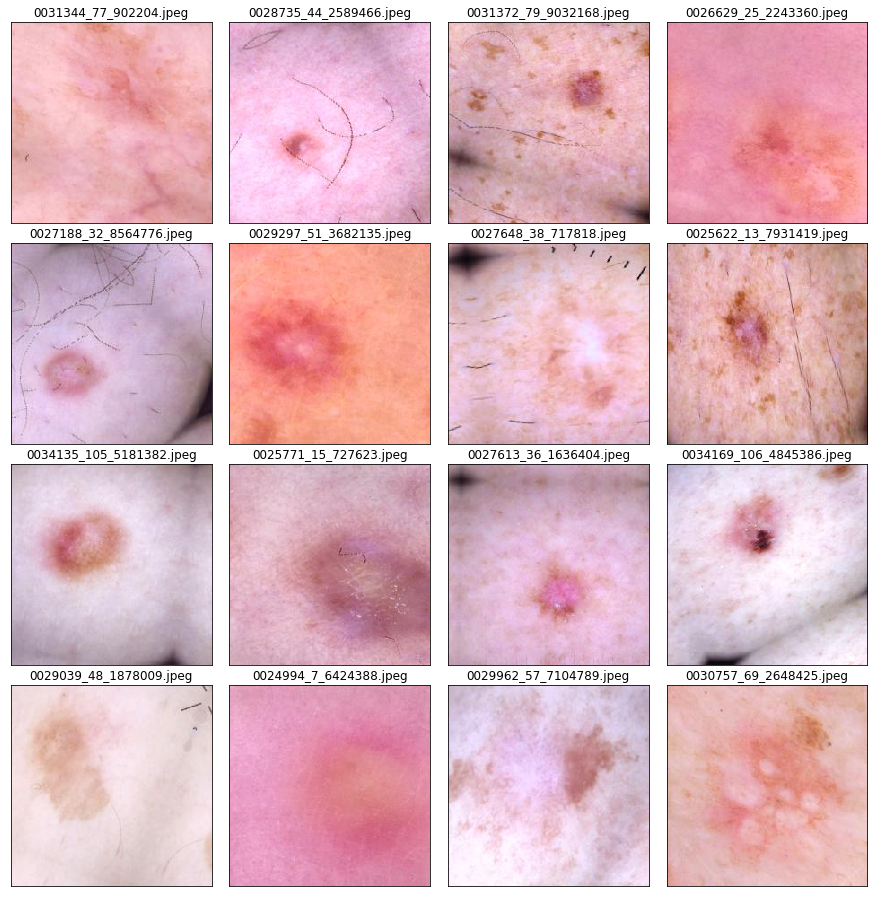

0030423_501_1646082.jpeg
0033871_959_3516939.jpeg
0025097_69_3167076.jpeg
0026352_164_255235.jpeg
0030910_534_2405151.jpeg
0033239_822_4614528.jpeg
0024482_11_5244974.jpeg
0034162_1034_6792373.jpeg
0034262_1056_835036.jpeg
0028847_374_1526509.jpeg
0027480_265_2505812.jpeg
0024640_24_2147350.jpeg
0026664_186_1428017.jpeg
0028228_329_6121281.jpeg
0027155_236_9769070.jpeg
0033643_915_3794520.jpeg


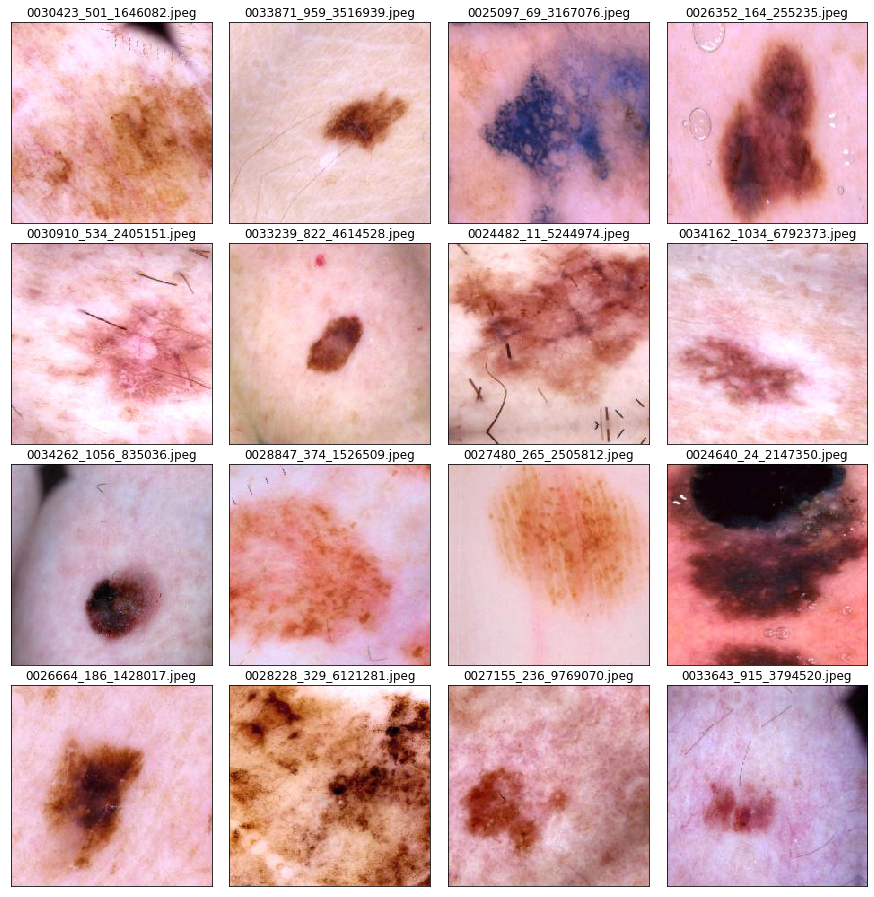

0030488_617_5308850.jpeg
0026679_238_3237400.jpeg
ISIC_0028920.jpg
0025337_99_9761592.jpeg
0025623_123_4998823.jpeg
0033124_862_8057158.jpeg
0024382_8_4666980.jpeg
0034175_995_3726180.jpeg
0031601_719_6907140.jpeg
0025851_150_8292712.jpeg
0031945_751_9301213.jpeg
0024748_41_6704599.jpeg
0032967_851_4333744.jpeg
0030436_613_9614348.jpeg
0027154_286_249839.jpeg
0030208_592_6445135.jpeg


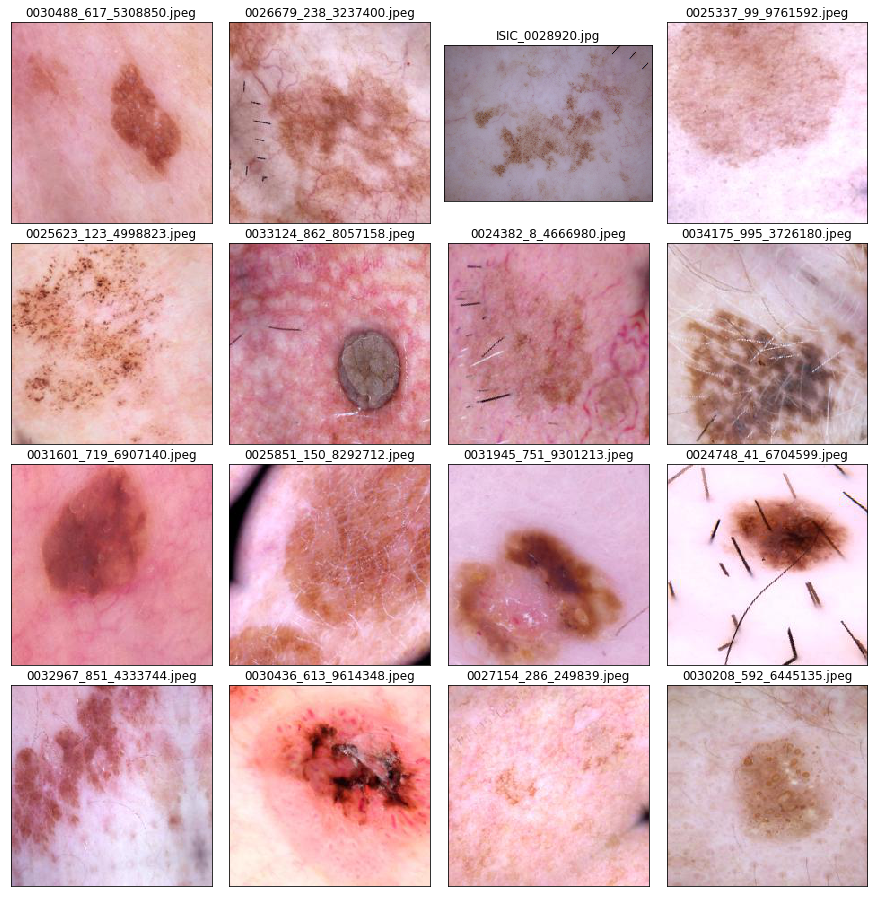

ISIC_0031169.jpg
0028155_189_4535725.jpeg
0024590_21_9195126.jpeg
0031976_387_2766030.jpeg
0024454_10_5100253.jpeg
0024799_30_325413.jpeg
0031062_335_4383113.jpeg
0031407_358_6438612.jpeg
0029779_274_5410669.jpeg
0026321_90_4811609.jpeg
0024799_30_9388062.jpeg
0029951_284_2719111.jpeg
0031489_363_9431685.jpeg
0027526_150_9969477.jpeg
0027546_154_4136248.jpeg
0028085_183_3294217.jpeg


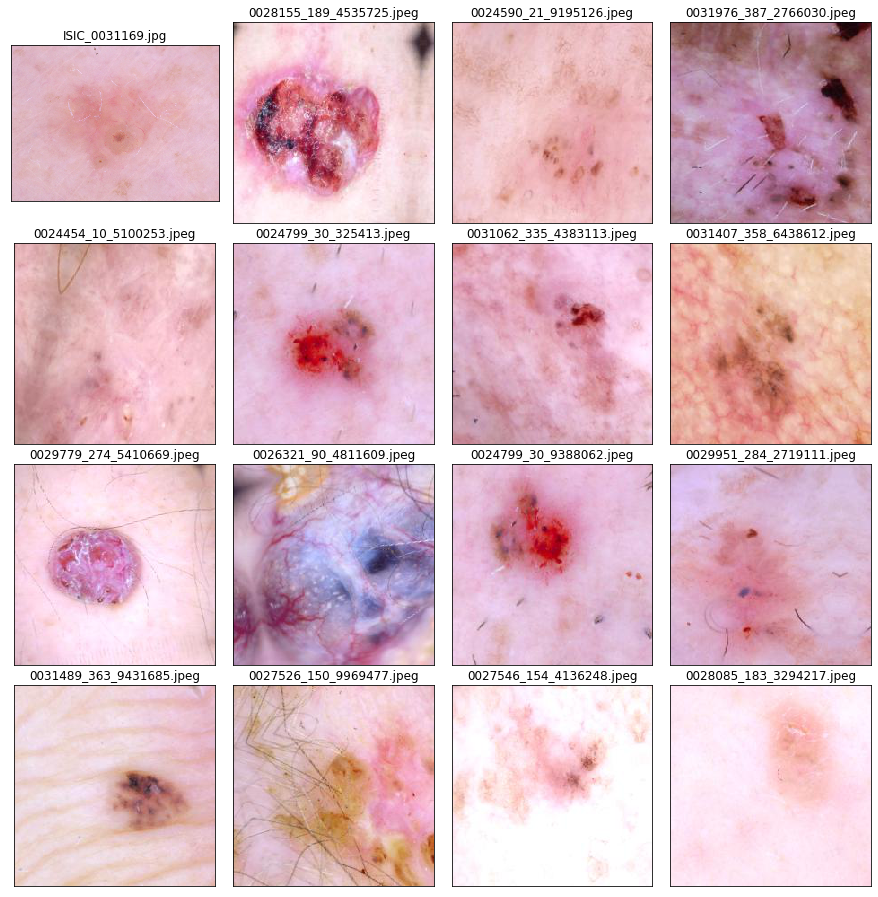

0025811_51_4711306.jpeg
ISIC_0025957.jpg
0027588_114_6630615.jpeg
0031692_257_6507811.jpeg
0027753_121_2044243.jpeg
0031993_264_6277604.jpeg
0025808_50_5520745.jpeg
0031506_251_595815.jpeg
0030245_207_7678440.jpeg
0032947_283_6597449.jpeg
0026178_66_1527725.jpeg
0031431_250_4198032.jpeg
0027577_112_3111309.jpeg
0025992_56_6900672.jpeg
0031874_261_8949872.jpeg
0030549_217_6917043.jpeg


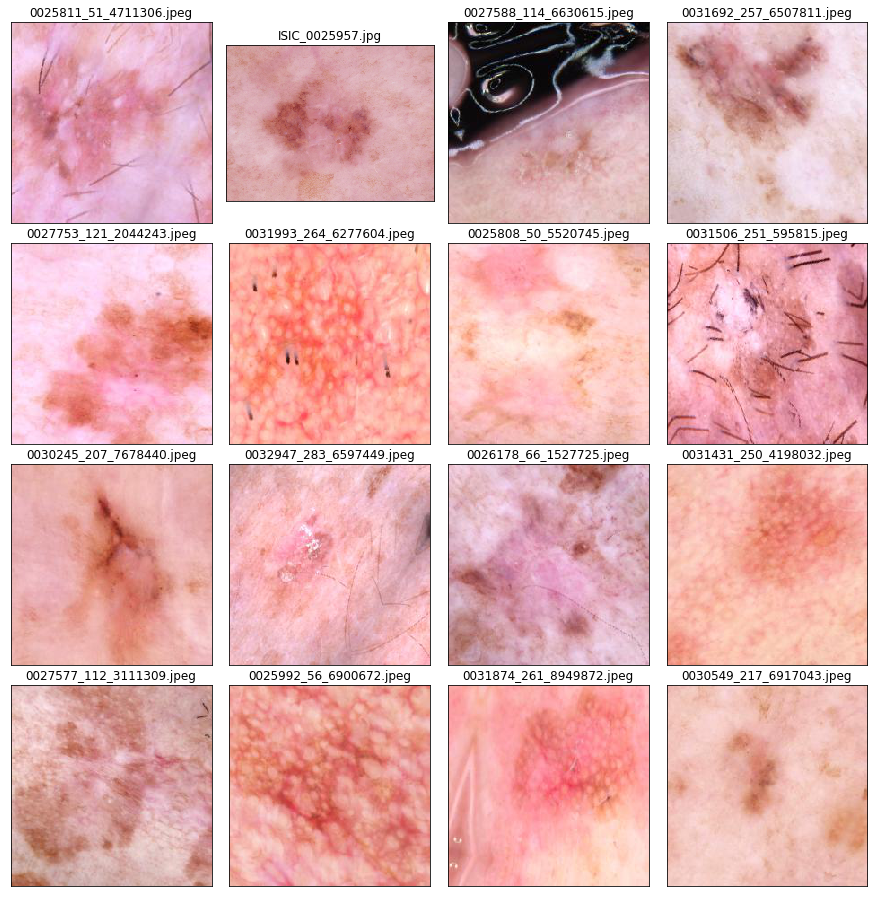

0032919_106_7947496.jpeg
0027672_43_9089230.jpeg
0025425_13_8083166.jpeg
0028431_52_1300171.jpeg
0026068_25_829780.jpeg
0026693_33_8733923.jpeg
0024867_8_9707828.jpeg
0032715_99_890565.jpeg
0027983_47_7896797.jpeg
0032545_95_6802595.jpeg
0031955_87_8814738.jpeg
0027937_46_5327617.jpeg
0027269_39_1356281.jpeg
0027672_43_1395350.jpeg
0025425_13_8828534.jpeg
0030275_66_8608658.jpeg


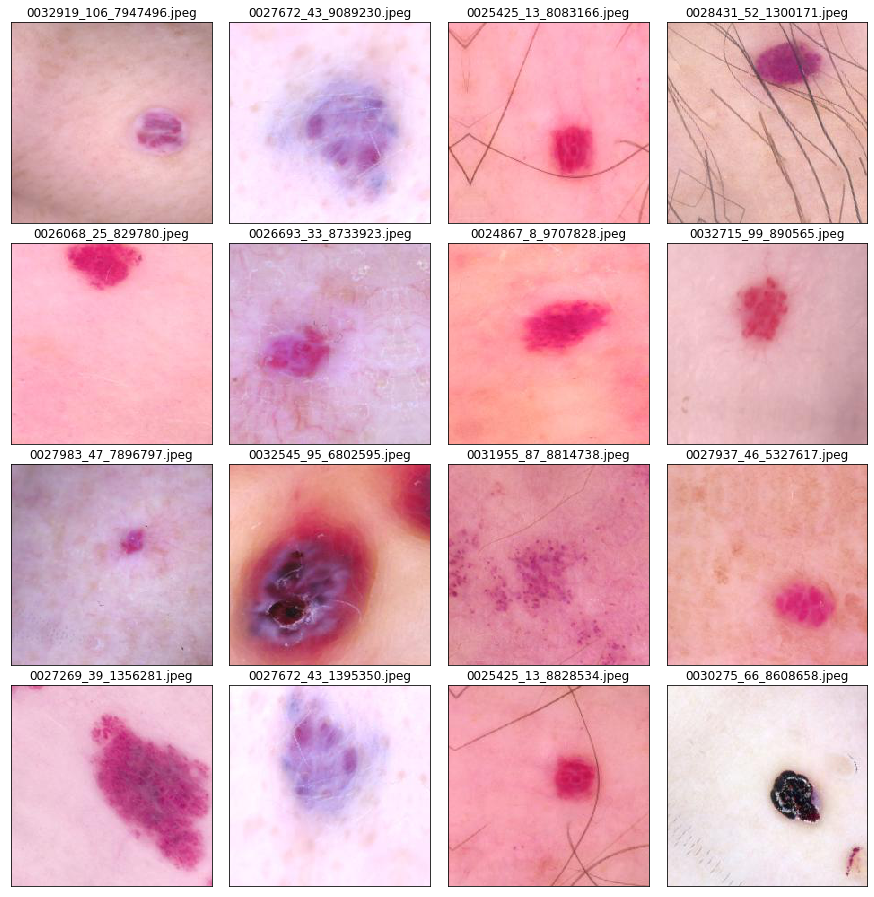

In [189]:
for d in diagnoses:
    generate_plot_pics(d)

### Rescale and Reshape all images (original + augmented)

In [95]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [96]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=50,
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=50,
)

Found 38890 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


### Setup model input

In [97]:
num_train_samples = len(train_data)
num_val_samples = len(val_data)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

## Transfer learning with pre-trained models

### Setup MobileNet

In [98]:
datagen = ImageDataGenerator(
    preprocessing_function= tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_dir,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(validation_dir,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(validation_dir,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38890 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [74]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [99]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

In [155]:
# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

#inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

# keras functional API, not Sequential
# inputs= identical to the original mobilenets input
model = Model(inputs=mobile.input, outputs=predictions)


In [156]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [157]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [158]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_3_accuracy])

In [100]:
# useful for plotting the confusion matrix
test_labels = test_batches.classes
print(valid_batches.class_indices)

In [151]:
class_weights={
    0: 2.0, # akiec
    1: 1.0, # bcc
    2: 3.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [242]:
train_batches.filenames[0:10]

['akiec/0024329_0_1063305.jpeg',
 'akiec/0024329_0_1220080.jpeg',
 'akiec/0024329_0_2024310.jpeg',
 'akiec/0024329_0_208423.jpeg',
 'akiec/0024329_0_2383774.jpeg',
 'akiec/0024329_0_2430030.jpeg',
 'akiec/0024329_0_2612176.jpeg',
 'akiec/0024329_0_3123228.jpeg',
 'akiec/0024329_0_3727905.jpeg',
 'akiec/0024329_0_5624435.jpeg']

In [123]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/30
891/892 [============================>.] - ETA: 0s - loss: 1.3410 - categorical_accuracy: 0.6859 - top_3_accuracy: 0.9457
Epoch 00001: val_top_3_accuracy improved from -inf to 0.86219, saving model to model.h5
892/892 [==============================] - 722s 809ms/step - loss: 1.3408 - categorical_accuracy: 0.6859 - top_3_accuracy: 0.9456 - val_loss: 1.9985 - val_categorical_accuracy: 0.4406 - val_top_3_accuracy: 0.8622
Epoch 2/30
891/892 [============================>.] - ETA: 0s - loss: 1.3521 - categorical_accuracy: 0.6939 - top_3_accuracy: 0.9465
Epoch 00002: val_top_3_accuracy improved from 0.86219 to 0.92203, saving model to model.h5
892/892 [==============================] - 622s 697ms/step - loss: 1.3529 - categorical_accuracy: 0.6938 - top_3_accuracy: 0.9465 - val_loss: 0.8346 - val_categorical_accuracy: 0.7897 - val_top_3_accuracy: 0.9220
Epoch 3/30
891/892 [============================>.] - ETA: 0s - loss: 1.2914 - categorical_accuracy: 0.7021 - top_3_accuracy: 0.9

Epoch 20/30
891/892 [============================>.] - ETA: 0s - loss: 0.6423 - categorical_accuracy: 0.8570 - top_3_accuracy: 0.9902
Epoch 00020: val_top_3_accuracy did not improve from 0.93382

Epoch 00020: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
892/892 [==============================] - 635s 712ms/step - loss: 0.6418 - categorical_accuracy: 0.8572 - top_3_accuracy: 0.9902 - val_loss: 1.0235 - val_categorical_accuracy: 0.6908 - val_top_3_accuracy: 0.9248
Epoch 21/30
891/892 [============================>.] - ETA: 0s - loss: 0.6540 - categorical_accuracy: 0.8580 - top_3_accuracy: 0.9893
Epoch 00021: val_top_3_accuracy did not improve from 0.93382
892/892 [==============================] - 662s 742ms/step - loss: 0.6533 - categorical_accuracy: 0.8582 - top_3_accuracy: 0.9893 - val_loss: 1.0969 - val_categorical_accuracy: 0.6736 - val_top_3_accuracy: 0.9175
Epoch 22/30
891/892 [============================>.] - ETA: 0s - loss: 0.6320 - categorical_accuracy: 0

### Get metrics for the best model (saved in model.h5)

In [166]:
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(val_data))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.8884706128138002
val_cat_acc: 0.7189483
val_top_3_acc: 0.93381685


### Display accuracy and loss curves

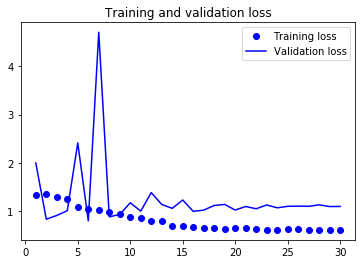

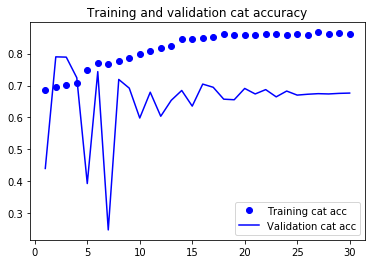

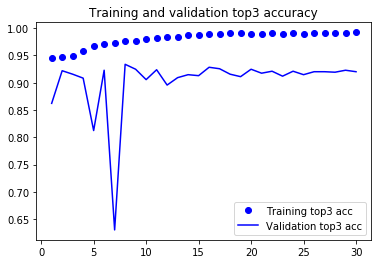

In [136]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Get predictions for test set

In [137]:
predictions = model.predict_generator(test_batches, steps=len(val_data), verbose=1)

1103/1103 [==============================] - 63s 57ms/step


In [289]:
cm_plot_labels = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]

In [149]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [150]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.39      0.43      0.41        30
         bcc       1.00      0.20      0.33        35
         bkl       0.53      0.24      0.33        88
          df       0.16      0.88      0.27         8
         mel       0.14      0.65      0.22        46
          nv       0.95      0.80      0.87       883
        vasc       0.45      0.38      0.42        13

    accuracy                           0.72      1103
   macro avg       0.52      0.51      0.41      1103
weighted avg       0.86      0.72      0.76      1103



# Merge CNN output with demographic data 

### Load demographic features for all images (augmented images included)

### Save meta df to pickle

In [319]:
meta.to_pickle("./meta.pkl")

In [205]:
# Create helper function to extract pure image_id's
def extract_id(x):
        
    if "ISIC" in x:
        return x[5:12]
    else:
        return  x[:7]

In [206]:
aug_img = pd.DataFrame(aug_list, columns=['aug_id'])
#aug_img["id_nr"] = aug_img.aug_id
aug_img['img_nr'] = aug_img['aug_id'].apply(extract_id)

In [207]:
complete_train = pd.merge(aug_img, meta, how='inner', on="img_nr", left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

In [320]:
complete_train.to_pickle("./aug_train.pkl")

### Create concatenated model

In [190]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [191]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

In [192]:
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

In [193]:
model_dem = Model(inputs=mobile.input, outputs=predictions)

In [198]:
model_dem.load_weights("model.h5")

In [214]:
img_inpt = model_dem.layers[-3].output